In [ ]:
pip install scikit-optimize

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Atur seed agar hasil tidak berubah-ubah
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = "/content/drive/MyDrive/Dataset/windnavigator.xls"

xls = pd.ExcelFile(file_path)
data = pd.read_excel(xls, sheet_name='Windnavigator_ERA5_N16.500_E41.')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Asumsikan kolomnya bernama: 'wind_speed', 'temperature', 'pressure'
wind_speed = data['wind_speed'].values
temperature = data['temperature'].values
pressure = data['pressure'].values

# Gabungkan data menjadi satu array untuk input ke GRU
data_combined = np.column_stack((wind_speed, temperature, pressure))

# Normalisasi data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_combined)

# Fungsi untuk membentuk input
def create_sequences(data, n_hours):
    X, y = [], []
    for i in range(n_hours, len(data)):
        X.append(data[i-n_hours:i])
        y.append(data[i, 0])  # target adalah kecepatan angin satu jam ke depan
    return np.array(X), np.array(y)

n_hours = 24  # Misalkan panjang input yang diinginkan adalah 5 jam sebelumnya
X, y = create_sequences(data_scaled, n_hours)

# Membagi data menjadi 70% training, 10% validasi, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, shuffle=False)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Testing samples: {len(X_test)}")

Training samples: 45847, Validation samples: 6550, Testing samples: 13100


In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((45847, 24, 3), (6550, 24, 3), (13100, 24, 3), (45847,), (6550,), (13100,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Attention, Concatenate, SimpleRNN
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from skopt import gp_minimize
from skopt.space import Real
import random

# Membangun model dengan Attention
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = LSTM(16, return_sequences=True)(input_layer)
gru_layer = GRU(16, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([lstm_layer, gru_layer])
rnn_layer = SimpleRNN(16, return_sequences=False)(attention_layer)
# Menggabungkan hasil Attention dan LSTM
#concat_layer = Concatenate()([lstm_layer, attention_layer])
dense_layer = Dense(1)(rnn_layer)

# Membuat model
model = Model(inputs=input_layer, outputs=dense_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
# Fungsi evaluasi untuk PSO
def evaluate(weights):
    structured_weights = []
    index = 0
    for layer_weights in model.get_weights():
        shape = layer_weights.shape
        size = np.prod(shape)
        structured_weights.append(np.array(weights[index:index + size]).reshape(shape))
        index += size

    model.set_weights(structured_weights)
    loss = model.evaluate(X_train, y_train, verbose=0)
    return (loss)  # <-- Changed this line

# Inisialisasi Surrogate Optimization
initial_weights = model.get_weights()
num_weights = sum([w.size for w in initial_weights])

space = [Real(-1, 1) for _ in range(num_weights)]

result = gp_minimize(evaluate, space, n_calls=10, random_state=42) #(DenganSurrogate)

# Menetapkan bobot terbaik ke model
optimal_weights = result.x #(DenganSurrogate)
#optimal_weights = space #TanpaSurrogate
structured_optimal_weights = []
index = 0
for layer_weights in model.get_weights():
    shape = layer_weights.shape
    size = np.prod(shape)
    structured_optimal_weights.append(np.array(optimal_weights[index:index + size]).reshape(shape))
    index += size

#model.set_weights(initial_weights) #TanpaSurrogate
model.set_weights(structured_optimal_weights)#(DenganSurrogate)
#model.compile(optimizer='adam', loss='mse')

model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 24, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 24, 16)    │      1,280 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 24, 16)    │      1,008 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 24, 16)    │          0 │ lstm_5[0][0],     │
│ (Attention)         │                   │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_5        │ (None, 16)        │        528 │ attention_5[0][0] │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         17 │ simple_rnn_5[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,833 (11.07 KB)

 Trainable params: 2,833 (11.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.0231 - val_loss: 0.0022
Epoch 2/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 3/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0010 - val_loss: 8.8072e-04
Epoch 4/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 9.1881e-04 - val_loss: 8.2832e-04
Epoch 5/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 8.7610e-04 - val_loss: 8.0328e-04
Epoch 6/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 8.4987e-04 - val_loss: 7.8756e-04
Epoch 7/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 8.3114e-04 - val_loss: 7.7792e-04
Epoch 8/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 8.1680e-04 - val_loss: 7.7207e-04
Epoch 9/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 8.0537e-04 - val_loss: 7.6748e-04
Epoch 10/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 7.9599e-04 - val_loss: 7.6307e-04


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

# Prediksi pada set test
y_pred = model.predict(X_test)

# Mengembalikan skala asli
y_test_inv = scaler.inverse_transform(np.column_stack((y_test, np.zeros((y_test.shape[0], 2)))))[:, 0]
y_pred_inv = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros((y_pred.shape[0], 2)))))[:, 0]

# Hitung metrik evaluasi
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")
print(f"MAE: {mae}")


410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
RMSE: 0.4752365588343026
MAPE: 0.11693589938654884
R²: 0.9823319640830255
MAE: 0.3327712848000855


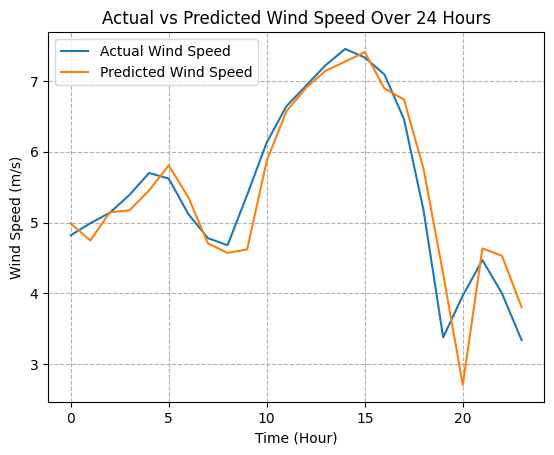

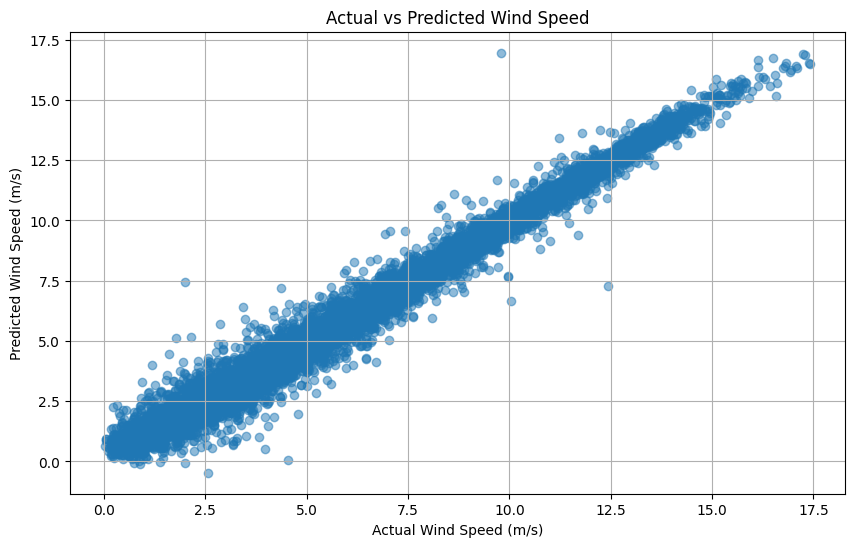

In [ ]:
import matplotlib.pyplot as plt
y_test_inv_24 = y_test_inv[-24:]
y_pred_inv_24 = y_pred_inv[-24:]

# Membuat array waktu 0 hingga 23 untuk merepresentasikan jam dalam satu hari
time = np.arange(0, 24, 1)  # 0 hingga 23 jam

# Plotting
plt.plot(time, y_test_inv_24, label='Actual Wind Speed')
plt.plot(time, y_pred_inv_24, label='Predicted Wind Speed')

# Menambahkan grid
plt.grid(which='both', linestyle='--')

# Menambahkan label sumbu x dan y
plt.xlabel('Time (Hour)')
plt.ylabel('Wind Speed (m/s)')

# Menambahkan judul (opsional)
plt.title('Actual vs Predicted Wind Speed Over 24 Hours')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.show()

# prompt: add scatter plot of x actual and y predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.xlabel("Actual Wind Speed (m/s)")
plt.ylabel("Predicted Wind Speed (m/s)")
plt.title("Actual vs Predicted Wind Speed")
plt.grid(True)
plt.show()